In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import keras

In [2]:
import skimage.io
import tqdm
import glob

In [3]:
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

%matplotlib inline

In [4]:
train_o = glob.glob('./DATASET/TRAIN/O/*.jpg')
a=len(train_o)
a

12565

In [5]:
train_r = glob.glob('./DATASET/TRAIN/R/*.jpg')
b=len(train_r)
b

9999

In [6]:
a+b

22564

In [7]:
train_datagen = ImageDataGenerator(rescale= 1.0 / 255.0, 
                                   zoom_range= 0.4,
                                   rotation_range= 10,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.2)

valid_datagen = ImageDataGenerator(rescale= 1.0 / 255.0,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale= 1.0 / 255.0)

In [8]:
train_dataset = train_datagen.flow_from_directory(directory='./DATASET/TRAIN/',
                                                  target_size=(224, 224),
                                                  class_mode= 'binary',
                                                  batch_size= 128,
                                                  subset= 'training')


Found 18052 images belonging to 2 classes.


In [9]:
valid_dataset = valid_datagen.flow_from_directory(directory='./DATASET/TRAIN/',
                                                  target_size=(224,224),
                                                  class_mode= 'binary',
                                                  batch_size= 128,
                                                  subset= 'validation'
                                                  )

Found 4512 images belonging to 2 classes.


In [10]:
train_dataset.class_indices

{'O': 0, 'R': 1}

100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


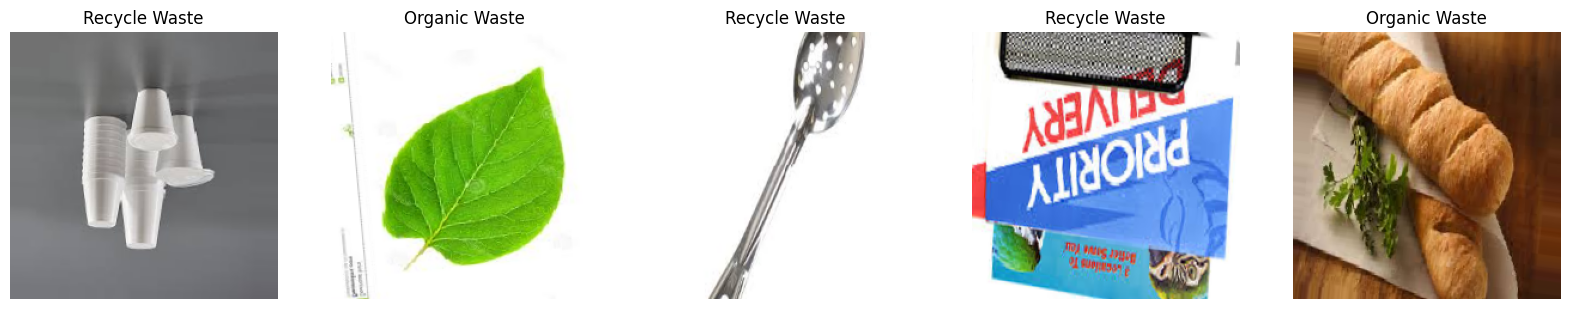

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,20))

for i in tqdm(range(5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(128)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    label = train_dataset[rand1][1][rand2]
    if label == 1:
        ax[i].set_title('Recycle Waste')
    else:
        ax[i].set_title('Organic Waste')

In [12]:
base_model = VGG16(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")

In [13]:
for layer in base_model.layers:
    layer.trainable = False

In [14]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# def my_leaky_relu(x):
#     return tensorflow.nn.leaky_relu(x, alpha=0.01)

In [16]:

model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                       

In [18]:
OPT = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy', metrics=[tensorflow.keras.metrics.AUC(name= 'auc')],optimizer=OPT)


In [19]:
# filepath='./best_weights.hdf5'

# earlystopping = EarlyStopping(monitor='val_auc',mode='max',patience=5,verbose=1)

# checkpoint = ModelCheckpoint(filepath,monitor ='val_auc',mode='max',save_best_only=True,verbose=1)

# callback_list=[earlystopping,checkpoint]


In [20]:
model_history = model.fit(train_dataset,validation_data=valid_dataset,epochs=15,verbose=1)

Epoch 1/15


: 

: 